# Allen atlas image regression

In [1]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
import ants
import nrrd
import scipy
import cv2
from PIL import Image
from EasyROI import EasyROI
from plantcv import plantcv as pcv
import nrrd
from polyroi import Shape

In [2]:
experiment_name = "test1_M36"

In [3]:
#directory = search_for_file_path()
rsp, tree = open_AllenSDK() #resolution of annotation can be changed with karg resolution. default = 25 micrometer
isocortex_map, id_name_dict, bregma = map_generator(rsp, tree, structure='Isocortex', depth=3)

#sma_mask = create_mask(isocortex_map, 656)
contour = create_contour(isocortex_map)

['annotation_25.nrrd']


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 2203.34it/s]


# Plotting regions and contours for open_AllenSDK validation

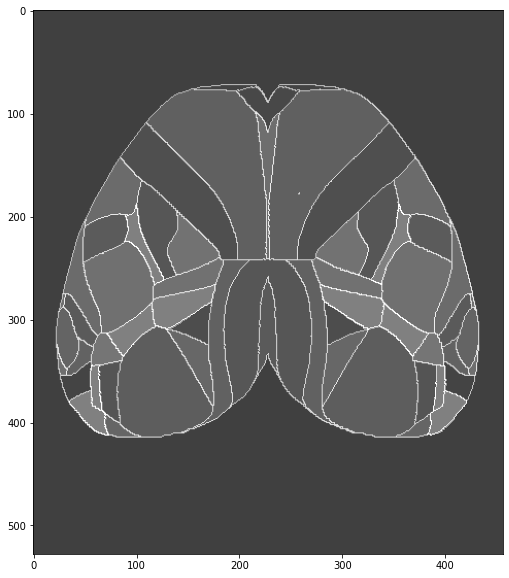

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(isocortex_map,vmax=1300, cmap='gray', alpha=0.5)
plt.imshow(contour, cmap='binary_r', alpha=0.5)
plt.show()

# Changing to local directory to save images and automate process

#### Also creates a new folder named experiment_name if it does not exist yet

In [5]:
# Changing directory for local_dir (where every registration will be made)
local_dir='/Users/vincentchouinard/Documents/Maitrise/Registration'
os.chdir(local_dir)


newfolderpath = "".join([local_dir,  '/', experiment_name])
newfolderpath = Path(newfolderpath)

if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)
    print('New folder named "{}" was created: Add picture(s) to the folder for the registration process.'.format(newfolderpath))

# Saving isocortex Mask

In [6]:
isocortex_mask = np.zeros(isocortex_map.shape)
mask_list = []
for i in id_name_dict:
    mask_list.append(i)
isocortex_mask = create_mask(isocortex_map, mask_list)
isocortex_mask_int8 = isocortex_mask.astype('uint8')

print('List of IDs in the cortex map imported from Allen  :  ', mask_list)

List of IDs in the cortex map imported from Allen  :   [68, 97, 171, 281, 320, 421, 442, 450, 484, 527, 542, 558, 593, 656, 671, 696, 735, 750, 805, 873, 878, 935, 959, 981, 1006, 1030, 1074, 182305693, 312782550, 312782578, 312782604, 312782632]


# Manually crop surgery image

In [7]:
def select_mask(image):
    # Initialize variables
    roi_points = []
    roi_completed = False

    def mouse_callback(event, x, y, flags, param):
        nonlocal roi_points, roi_completed
        
        

        if event == cv2.EVENT_LBUTTONDOWN:
            roi_points.append((x, y))
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)

            if len(roi_points) > 1:
                cv2.line(image, roi_points[-2], roi_points[-1], (0, 0, 255), 5)


    # Create a window to display the image
    cv2.namedWindow('Select ROI')
    cv2.imshow('Select ROI', image)

    # Register the mouse callback function
    cv2.setMouseCallback('Select ROI', mouse_callback)
    while not roi_completed:
        cv2.imshow('Select ROI', image)
        cv2.waitKey(4)
        
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):  # Press 'q' to quit cropping
            break

    cv2.destroyAllWindows()

    # Convert the ROI points to a NumPy array
    roi_points = np.array(roi_points)

    # Create a binary mask
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    cv2.fillPoly(mask, [roi_points], 1)
    

    return mask

In [8]:
surgery_image_path = search_for_file_path()
surgery_mask = select_mask(surgery_image_path)
surgery_mask_name = experiment_name + "_surgery_mask"
npy_to_tif(surgery_mask, surgery_mask_name, path=surgery_image_path)

TypeError: Expected Ptr<cv::UMat> for argument 'mat'

In [7]:
def npy_to_tif(data, name, path = None):
    if path is not None:
        
    
    if path == 'search':
        path = search_for_file_path()

    data = data.astype('uint8')
    print(data.dtype)
    im = Image.fromarray(data)
    im.save(os.path.join(path, name + ".tif"))
    return

def tif_to_nrrd(filename, path):
    img = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)
    filename = Path(filename).stem
    nrrd.write(path + "/" + filename + '.nrrd', img)
    return filename + '.nrrd'

In [15]:
new_contour = create_contour(isocortex_map)
new_contour_name = "contour_" + experiment_name



In [ ]:
tif_to_nrrd("contour.tif")

In [ ]:
#im = Image.fromarray(isocortex_mask_int8)
#im.save(os.path.join(filePath, image_name + ".tif"))

# Opening both masks and finding transform

In [ ]:
#atlas_array = cv2.imread("/Users/vincentchouinard/Documents/GitHub/Atlas/saved_images/isocortex_mask.tif")
#atlas_array = cv2.imread("/Users/vincentchouinard/Documents/GitHub/Atlas/saved_images/isocortex_churchland_mask_int8.tif")
#atlas_array = atlas_array[:,:,0].astype('uint8')
#print(atlas_array.dtype)
#print(atlas_array[200,200])
#print(atlas_array[3,7])

In [ ]:
#atlas_array = atlas_array/255
#atlas_array = atlas_array.astype("uint8")
#plt.imshow(atlas_array, cmap="binary_r")
#plt.colorbar()
#plt.show()
#print(atlas_array.dtype)
#print(atlas_array[200,200])
#print(atlas_array[3,7])

In [ ]:
name = 'contour'
im = Image.fromarray(contour)
im.save(os.path.join(path, name + ".tif"))

In [ ]:
contour_ants = ants.image_read(directory + "/saved_images/contour.nrrd")

In [ ]:
#img = cv2.imread(directory + "/" + "saved_images/isocortex_mask_churchland_int8.tif", cv2.IMREAD_GRAYSCALE)

In [ ]:
def tif_to_nrrd(filename, path):
    img = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)
    filename = Path(filename).stem
    nrrd.write(path + "/" + filename + '.nrrd', img)
    return filename + '.nrrd'

In [ ]:
# Opens both files in the directory I choose
tif_to_nrrd("isocortex_churchland_mask_v3.tif")
#tif_to_nrrd("isocortex_mask_int8.tif")

In [ ]:
#churchland_nrrd, header = nrrd.read(directory + "/saved_images/isocortex_mask_churchland_int8.nrrd")
#print(header)
#header['space directions'] = np.delete(header['space directions'], 2, 1)
#header['space directions'] = np.array([[30, 0],[0,30]])
#print(header)

In [ ]:
churchland = ants.image_read(directory + "/saved_images/isocortex_churchland_mask_v3.nrrd")
atlas = ants.image_read(directory + "/saved_images/isocortex_mask_int8.nrrd")

In [ ]:
#churchland = ants.image_read(directory + "/saved_images/rot_isocortex_mask_churchland_int8.nrrd")

In [ ]:
#atlas = ants.image_read(directory + "/saved_images/isocortex_mask_int8.nrrd")
contour_ants = ants.image_read("contour.nrrd")

In [ ]:
mytx = ants.registration(fixed=churchland, moving=atlas, type_of_transform = ('SyN'), syn_sampling = 8)

In [ ]:
#print(mytx)

In [ ]:
atlas_warped = ants.apply_transforms(churchland, atlas, mytx['fwdtransforms']).numpy()
contours_warped = ants.apply_transforms(churchland, contour_ants, mytx['fwdtransforms']).numpy()

In [ ]:
path = search_for_file_path()
filename = 'isocortex_churchland.tif'
img = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(atlas_warped, alpha=0.5)
plt.imshow(contours_warped, cmap='binary_r', alpha=0.8)
#plt.imshow(churchland.numpy(), alpha=0.5)
plt.imshow(img, cmap='binary_r', alpha=0.6)

In [ ]:
registrationPath = search_for_file_path()

#fixedname = ''
#fixed = search_for_file_path()
#fixed = fixed + '/' fixedname


In [ ]:
def registration(registrationPath, folderName, fixed_filename, moving_filename, trsfm = 'SyN', sampling = 8, show='off'):
    #Creates new folder at registrationPath with name folderName. If folder already existant, closes function.
    newFolder = registrationPath + "/" + folderName
    
    if os.path.exists(newFolder):
        print(f'{folderName} already exists.')
        if identify_files(newFolder, fixed_filename) == [fixed_filename]:
            tif_to_nrrd(fixed_filename, newFolder)
            tif_to_nrrd(moving_filename, newFolder)
        else:
            print('Insert .tif files in folder before registering.')
            return
    
    else:
        print(f'Creating a folder named {folderName} in {registrationPath}')
        os.mkdir(newFolder)
        
        #Opens fixed and moving images
        print('Opening fixed .tif image')
        fixed = search_for_file_path()
        fixedImg = cv2.imread(fixed + "/" + fixed_filename, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(newFolder + '/' + fixed_filename, fixedImg)
        nrrd_fixedname = tif_to_nrrd(fixed_filename, newFolder)
    
    
        print('Opening moving .tif image')
        moving = search_for_file_path()
        movingImg = cv2.imread(moving + "/" + moving_filename, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(newFolder + '/' + moving_filename, movingImg)
        nrrd_movingname = tif_to_nrrd(moving_filename, newFolder)
    
    # .tif and .nrrd created.
    
    ants_fixedImg = ants.image_read(newFolder + '/' + nrrd_fixedname)
    ants_movingImg = ants.image_read(newFolder + '/' + nrrd_movingname)
    mytx = ants.registration(fixed=ants_fixedImg, moving=ants_movingImg, type_of_transform = trsfm, syn_sampling = sampling)
    warpedImg = ants.apply_transforms(ants_fixedImg, ants_movingImg, mytx['fwdtransforms']).numpy()
    
    if show == 'on':
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(warpedImg, cmap='PiYG', alpha=0.5)
        plt.imshow(fixedImg, cmap='PuOr', alpha=0.5)
    
    return mytx, ants_fixedImg, ants_movingImg, warpedImg

In [ ]:
trsfm, fixed, moving, warped = registration(registrationPath, 'churchland_contours', 'isocortex_churchland_mask_v3.tif', 'isocortex_mask_int8.tif', show='on')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(warped, cmap='PiYG', alpha=0.5)
plt.imshow(fixed.numpy(), cmap='binary_r', alpha=0.5)
#plt.imshow(moving.numpy(), cmap='binary_r', alpha=0.5)
plt.show()
    

In [2]:
path = search_for_file_path()
filename = 'isocortex_churchland.tif'
img_raw = cv2.imread(path + "/" + filename, cv2.IMREAD_GRAYSCALE)
roi_helper = EasyROI(verbose=True)
polygon_roi = roi_helper.draw_polygon(img_raw, 1)
contour, hierarchy = pcv.roi.custom(img=img_raw, vertices=polygon_roi["roi"][0]["vertices"])
mask = pcv.roi.roi2mask(img=img_raw, contour=contour)

You chose: /Users/vincentchouinard/Desktop
[DEBUG] Welcome to easyROI
[DEBUG] Entered draw_polygon
[DEBUG] Draw 1 polygon(s)
[DEBUG] Draw multiple lines by dragging the cursor
[DEBUG] Double Click to complete the polygon
[DEBUG] Press Esc to leave the process
[DEBUG] Not all ROI's drawn


KeyError: 'roi'

# TESTS

In [7]:
%matplotlib qt

image_path = '/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_203336410.jpg'
img = cv2.imread(image_path)

In [ ]:
# Select ROI
roi_mask = select_roi(img)

# Display the selected ROI mask
cv2.imshow('Selected ROI Mask', roi_mask)
cv2.waitKey(2)
cv2.destroyAllWindows()

In [9]:
plt.imshow(roi_mask)